In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import math
from scipy.stats import mode

# Load Estimation of Occupancy Calculated by Openpose

In [2]:
occupancy_whole = pd.read_csv('test_video_processed_occupancy_whole.txt', sep=',', header=None)
occupancy_core = pd.read_csv('test_video_processed_occupancy_core.txt', sep=',', header=None)
occupancy_margin = pd.read_csv('test_video_processed_occupancy_margin.txt', sep=',', header=None)

<IPython.core.display.Javascript object>


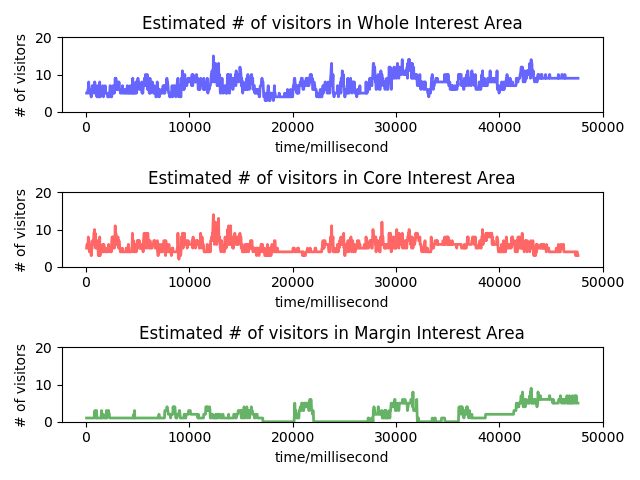

In [3]:
plt.figure()
# Whole Interest Area
plt.subplot(3, 1, 1)
plt.plot(occupancy_whole[0], occupancy_whole[1], 'b-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Whole Interest Area')
#plt.grid(True)

# Core Interest Area
plt.subplot(3, 1, 2)
plt.plot(occupancy_core[0], occupancy_core[1], 'r-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Core Interest Area')
#plt.grid(True)

# Margin Interest Area
plt.subplot(3, 1, 3)
plt.plot(occupancy_margin[0], occupancy_margin[1], 'g-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Margin Interest Area')
#plt.grid(True)

plt.tight_layout()
plt.show()

## Compare Estimated Occupancy in Whole Interest Area and the Sum of Estimated Occupancies in Core and Margin Area 

<IPython.core.display.Javascript object>


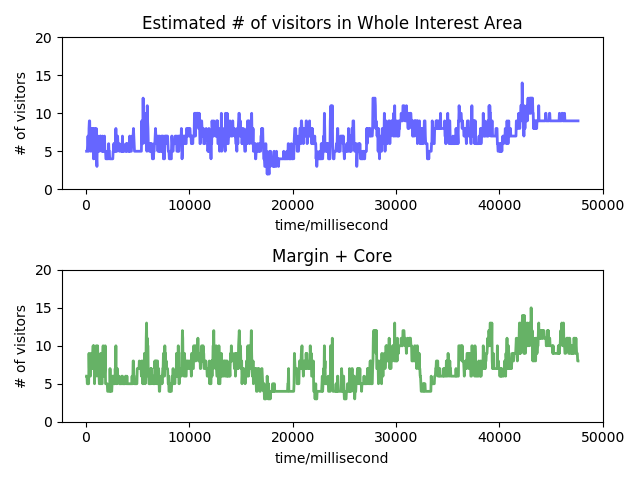

In [4]:
plt.figure()
# Whole Interest Area
plt.subplot(2,1,1)
plt.plot(occupancy_whole[0], occupancy_whole[1], 'b-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Whole Interest Area')
# Margin + Core Interest Area
plt.subplot(2,1,2)
plt.plot(occupancy_margin[0], occupancy_margin[1]+occupancy_core[1], 'g-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Margin + Core')
#plt.grid(True)

plt.tight_layout()
plt.show()

The time interval between two estimates is around 33 millisedonds. Thus, if we assume people will stay at the same place within one second. We can average over a sliding window of size 30.

In [4]:
print('The time interval between two estimates: {} milliseconds'.format(occupancy_whole[0][1]-occupancy_whole[0][0]))

The time interval between two estimates: 33.3326330532213 milliseconds


# Smoothen Estimations of # of Visitors in Three Areas calculated by Openpose

## Sliding Window Smoothing Method (self-defined)

In [5]:
import pdb
def moving_smoothing(values, window_size, smooth_type='mode', stride = 1):
    """
    Smoothen estimated occupancy.
    Args:
        values (pandas.DataFrame): 
            values[0]: time in millisecond
            values[1]: estimated # of visitors
        window_size(int): the size of sliding window
        smooth_type (string): 
            1. 'mode'
            2. 'mean'
            3. 'min'
            4. 'median'
        stride (int): the stride between two consecutive windows
    Returns:
        smooth_time (list): smooth time i.e. the max time in each window
        smooth_occupancy (list): smooth occupancy i.e. the mode occupancy in each window
    """
    group_time = []
    group_occupancy = []
    for i in range(0, math.ceil((len(values[0])-window_size+1)/stride)):
        group_time.append(values[0][i:i+window_size])
        group_occupancy.append(values[1][i:i+window_size])
    
    smooth_time = []
    smooth_occupancy = []
    for i in range(len(group_time)):
        smooth_time.append(min(group_time[i])) # max time in the group
        if smooth_type == 'mode':
            smooth_occupancy.append(mode(group_occupancy[i])[0][0]) # mode occupancy in the group
        elif smooth_type == 'mean':
            smooth_occupancy.append(np.round(np.mean(group_occupancy[i])))
        elif smooth_type == 'min':
            smooth_occupancy.append(np.round(np.min(group_occupancy[i])))
        elif smooth_type == 'median':
            smooth_occupancy.append(np.round(np.median(group_occupancy[i])))
        else:
            print('Please choose a proper smooth_type.')
    return smooth_time, smooth_occupancy

In [6]:
window_size = 30
smooth_type='median'
stride = 1

<IPython.core.display.Javascript object>


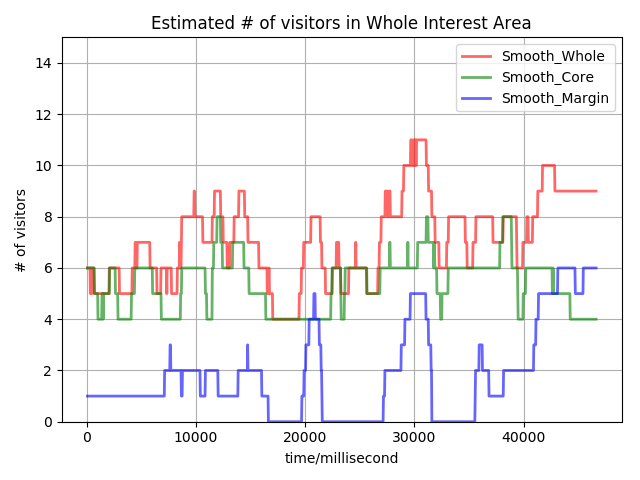

In [7]:
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

plt.figure()
# Whole Interest Area
plt.plot(smooth_time_whole, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(smooth_time_core, smooth_occupancy_core, 'g-', lw=2, alpha=0.6)
# Margin Interest Area
plt.plot(smooth_time_margin, smooth_occupancy_margin, 'b-', lw=2, alpha=0.6)
plt.legend(('Smooth_Whole','Smooth_Core','Smooth_Margin'))

plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=15)
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

plt.tight_layout()
plt.show()

### Smoothen then Add

<IPython.core.display.Javascript object>


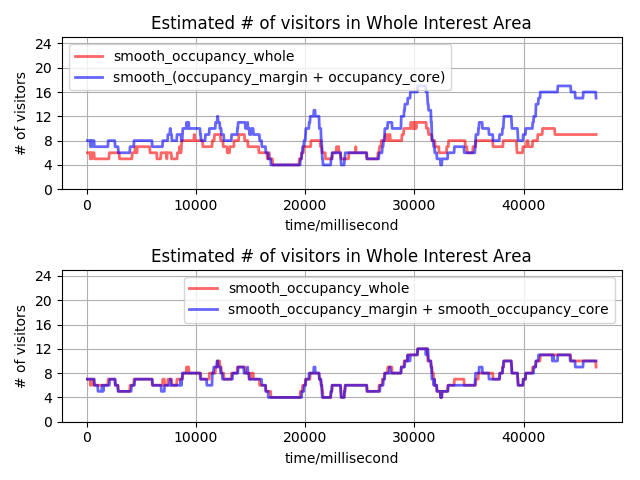

In [8]:
plt.figure()
plt.subplot(2,1,1)
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
occupancy_margin_add_core = occupancy_whole
occupancy_margin_add_core[1] = occupancy_core[1] + occupancy_margin[1]
smooth_time_margin_add_core, smooth_occupancy_margin_add_core = moving_smoothing(occupancy_margin_add_core, window_size, smooth_type)

# Whole Interest Area
plt.plot(smooth_time_whole, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(smooth_time_margin_add_core, np.array(smooth_occupancy_margin_add_core)+np.array(smooth_occupancy_margin), 'b-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_(occupancy_margin + occupancy_core)'))
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

# Add then Smoothen
plt.subplot(2,1,2)
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

# Whole Interest Area
plt.plot(smooth_time_whole, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(smooth_time_whole, np.array(smooth_occupancy_core)+np.array(smooth_occupancy_margin), 'b-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_occupancy_margin + smooth_occupancy_core'))
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

plt.tight_layout()
plt.show()

## Sliding Window Average Smoothing Method

In [9]:
# This is not good
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    average = np.convolve(values, weights, 'valid')
    # the average number should be int
    average = np.round(average)
    return average

In [10]:
window_size = 30

<IPython.core.display.Javascript object>


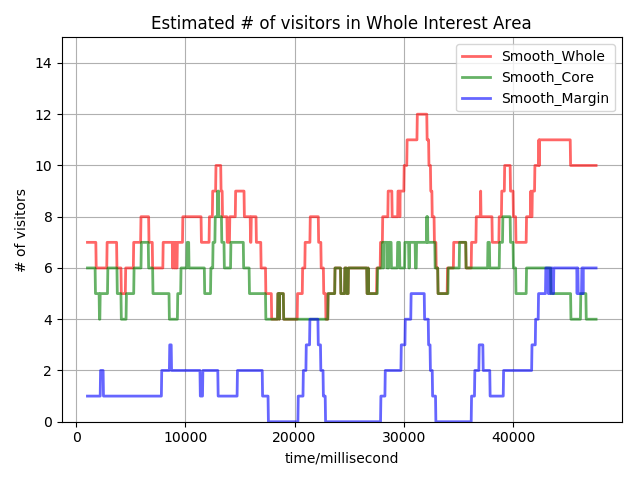

In [11]:
smooth_occupancy_whole = movingaverage(occupancy_whole[1],window_size)
smooth_occupancy_core = movingaverage(occupancy_core[1],window_size)
smooth_occupancy_margin = movingaverage(occupancy_margin[1],window_size)

plt.figure()
time = occupancy_whole[0][len(occupancy_whole[0])-len(smooth_occupancy_whole):]
# Whole Interest Area
plt.plot(time, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(time, smooth_occupancy_core, 'g-', lw=2, alpha=0.6)
# Margin Interest Area
plt.plot(time, smooth_occupancy_margin, 'b-', lw=2, alpha=0.6)
plt.legend(('Smooth_Whole','Smooth_Core','Smooth_Margin'))

plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=15)
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

plt.tight_layout()
plt.show()

### Compare
1. subplot 1: First add seperate estimations of core and margin, then smoothen
2. subplot 2: First smoothen estimateions of core and margin seperatively, then add smoothend estimations together.

<IPython.core.display.Javascript object>


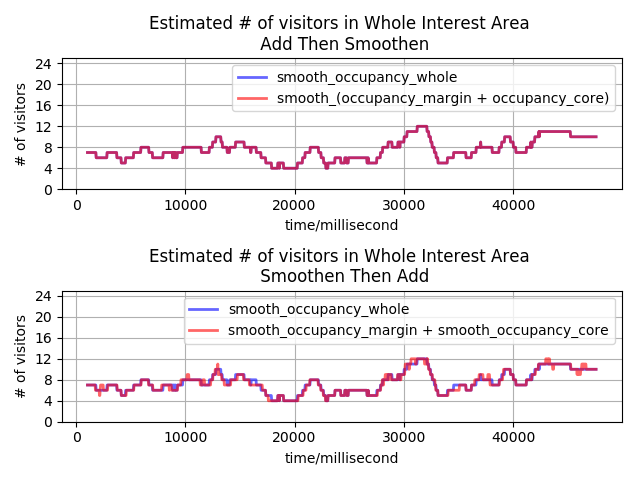

In [12]:
plt.figure()

# Add then Smoothen
plt.subplot(2,1,1)
smooth_occupancy_whole = movingaverage(occupancy_whole[1],window_size)
smooth_occupancy_margin_plus_core = movingaverage(occupancy_margin[1]+occupancy_core[1],window_size)

time = occupancy_whole[0][len(occupancy_whole[0])-len(smooth_occupancy_whole):]
# Whole Interest Area
plt.plot(time, smooth_occupancy_whole, 'b-', lw=2, alpha=0.6)
# Margin + Core Interest Area
plt.plot(time, smooth_occupancy_margin_plus_core, 'r-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_(occupancy_margin + occupancy_core)'))
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area \n Add Then Smoothen')
plt.grid(True)

# Smoothen then Add
plt.subplot(2,1,2)
smooth_occupancy_whole = movingaverage(occupancy_whole[1],window_size)
smooth_occupancy_core = movingaverage(occupancy_core[1],window_size)
smooth_occupancy_margin = movingaverage(occupancy_margin[1],window_size)

time = occupancy_whole[0][len(occupancy_whole[0])-len(smooth_occupancy_whole):]
# Whole Interest Area
plt.plot(time, smooth_occupancy_whole, 'b-', lw=2, alpha=0.6)
# Margin + Core Interest Area
plt.plot(time, smooth_occupancy_core+smooth_occupancy_margin, 'r-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_occupancy_margin + smooth_occupancy_core'))
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area \n Smoothen Then Add')
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyze Visitors' Movement

## Senario Truth Table
**First three columns** correspond the variation tendency of the number of visitors in three area i.e. Core, Margin and Whole Interest Area. 
The codes for three variation tendencies are:
* 0: hold
* 1: increase
* 2: decrease

The **forth column** indicates whether the senario possible in reality assuming the estimates of the number of visitors in three areas are accurate. Sepcifically,
* 0: impossible senario
* 1: possible senarios

The **fifth column** gives explanation on the senario.

In [13]:
senarios_truth_table = pd.read_csv('analize_visitor_in_and_out_senario_truth_table.csv')
senarios_truth_table

,# of visitors in core area: x,# of visitors in margin: y,# of visitors in whole interest area: z,Truth value,Explanation
0,0,0,0,1,No people transform between space.
1,0,0,1,0,Impossible
2,0,0,2,0,Impossible
3,0,1,0,0,Impossible
4,0,1,1,0,New people come in
5,0,1,2,0,Impossible
6,0,2,0,0,Impossible
7,0,2,1,0,Impossible
8,0,2,1,1,People get out
9,1,0,0,0,Impossible


In [14]:
window_size = 30
smooth_occupancy_whole = movingaverage(occupancy_whole[1],window_size)
smooth_occupancy_core = movingaverage(occupancy_core[1],window_size)
smooth_occupancy_margin = movingaverage(occupancy_margin[1],window_size)

<IPython.core.display.Javascript object>


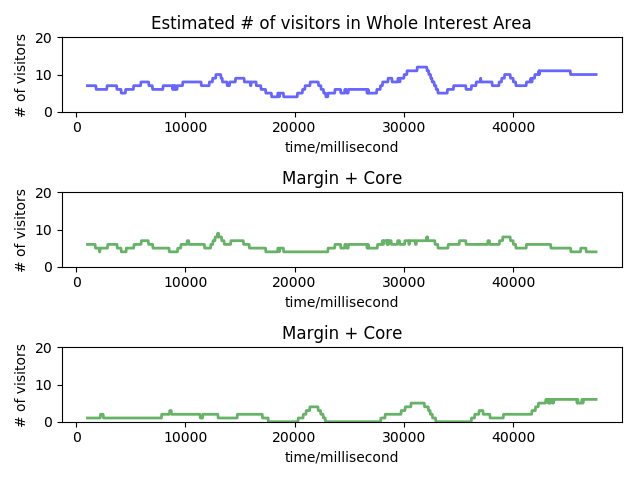

In [15]:
plt.figure()
# Smooth Whole Interest Area
plt.subplot(3,1,1)
plt.plot(occupancy_whole[0][len(occupancy_whole[0])-len(smooth_occupancy_whole):], smooth_occupancy_whole, 'b-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Whole Interest Area')

# Smooth Core Interest Area
plt.subplot(3,1,2)
plt.plot(occupancy_whole[0][len(occupancy_whole[0])-len(smooth_occupancy_core):], smooth_occupancy_core, 'g-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Margin + Core')

# Smooth Margin Interest Area
plt.subplot(3,1,3)
plt.plot(occupancy_whole[0][len(occupancy_whole[0])-len(smooth_occupancy_margin):], smooth_occupancy_margin, 'g-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Margin + Core')

plt.tight_layout()
plt.show()

In [24]:
smooth_occupancy_margin

array([2., 2., 2., ..., 6., 6., 6.])

In [14]:
round(1.8)

2